## COS748 - Busca e Mineração de Texto (Trabalho Final)
**Alunos:**
- Pedro Boechat
- Pedro Kuchpil

<hr>

### Imports

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

import fasttext
import re
import math

from nltk import corpus, stem

from collections import Counter

from wordcloud import WordCloud

### Load dataset

In [2]:
df = pd.read_json(
    "./data/data.zip",
    orient="records"
)

In [3]:
df["year"] = df["created.date-parts"].apply(lambda x: x[0][0] if isinstance(x, list) else None)

### Exploratory Data Analysis

#### 1) Titles

In [4]:
print(f"There are {df['title'].dropna().shape[0]} ({df['title'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null titles.")

There are 68211 (96.42%) non-null titles.


In [5]:
print("Titles that appear more than twice:")
display({
    key: value
    for key, value in df["title"].astype(str).value_counts(dropna=False).items()
    if value > 2
})

Titles that appear more than twice:


{'None': 2529,
 '[]': 177,
 'Editorial': 30,
 'Apresentação': 19,
 '[NO TITLE AVAILABLE]': 14,
 'TheHerschelVirgo Cluster Survey': 14,
 'Some Items of Interest to Process R&D Chemists and Engineers': 12,
 '': 7,
 'Abstracts': 7,
 'Preface': 5,
 'Groupware: Design, Implementation, and Use': 5,
 'The authors reply': 4,
 'EDITORIAL': 4,
 'Inductive Logic Programming': 3,
 'In Reply': 3,
 'Reply': 3,
 "Authors' response": 3,
 'Palavras dos Editores': 3,
 'APRESENTAÇÃO': 3}

#### 2) Abstract

In [6]:
print(f"There are {df['abstract'].dropna().shape[0]} ({df['abstract'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null abstracts.")

There are 17290 (24.44%) non-null abstracts.


#### 3) Subject

In [7]:
print(f"There are {df['subject'].dropna().shape[0]} ({df['subject'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null subjects.")

There are 57948 (81.92%) non-null subjects.


#### 4) Year

In [8]:
print(f"There are {df['year'].dropna().shape[0]} ({df['year'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null years.")

There are 68207 (96.42%) non-null years.


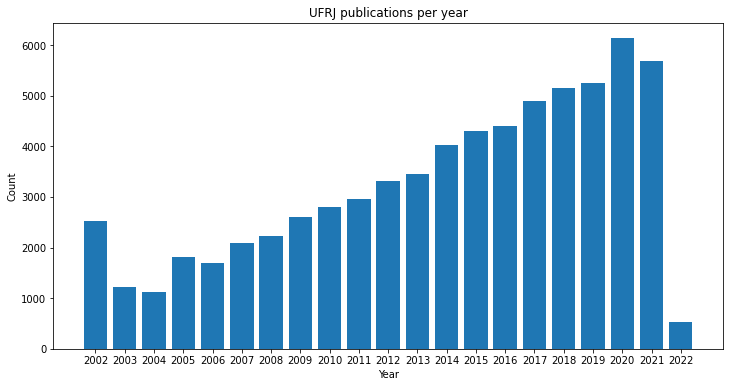

In [9]:
_ = df['year'].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(_.keys(), _.values())
ax.set_xticks(list(_.keys()))
ax.set_title("UFRJ publications per year")
ax.set_xlabel("Year")
ax.set_ylabel("Count");

#### 5) Language

In [10]:
df["language"].value_counts(dropna=False)

en      44193
None    26226
pt        205
fr         57
es         37
de         21
ja          1
Name: language, dtype: int64

In [11]:
df.loc[pd.isna(df["language"])]["title"].dropna().sample(10)

27835    Quality Of Care As Perceived By Patients In A ...
57186    Ligadura da veia porta associada à bipartição ...
57381    Information fusion techniques applied to Share...
60757    Comments on the genus Diplura C. L. Koch, 1850...
1043     The Hubble Space Telescope UV Legacy Survey of...
5651     Flavonoid Hesperidin Induces Synapse Formation...
7789     Ultra-Deepwater Model Testing of a Semisubmers...
21314    Efficacy of music therapy in the neuropsychiat...
34052    Estimativa das emissões de gases de efeito est...
66773    International Development in the Brazilian Con...
Name: title, dtype: object

In [12]:
df = df.replace(r'\n',' ', regex=True) 

In [13]:
path_to_pretrained_model = 'data/lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)
#preds = [fmodel.predict(t) for t in df['title'].dropna().tolist()]

In [14]:
for index, row in df.iterrows():
    row = row.copy()
    if (row['abstract'] != None):
        label, n = fmodel.predict(row['abstract'])
        if label != [] and n[0] > 0.9:
            df.loc[index, 'language'] = label[0][9:11]

In [15]:
df["language"].value_counts(dropna=False)

en      47045
None    16532
pt       6934
es        140
fr         62
de         23
it          2
ja          1
ca          1
Name: language, dtype: int64

#### Tag clouds

In [16]:
df = df.loc[df['language'] == 'en']

In [32]:
df = df.loc[df.explode('subject')['subject']]

General Medicine           4885
Biochemistry               2963
Molecular Biology          2475
General Chemistry          2350
Infectious Diseases        1998
                           ... 
Podiatry                      1
Nursing (miscellaneous)       1
Critical Care                 1
Conservation                  1
Pediatrics                    1
Name: subject, Length: 332, dtype: int64

In [17]:
df["language"].value_counts(dropna=False)

en    47045
Name: language, dtype: int64

In [18]:
df['title'] = df['title'].str.replace(r'<[^<>]*>', '', regex=True)

In [19]:
df = df[df['title'].notna()]


In [20]:
stopwords = corpus.stopwords.words('english') + corpus.stopwords.words('portuguese')
df['title'] = df.title.str.replace("[^\w\s]", "", regex=True).str.lower()

df['title'] = df['title'].apply(lambda x: [item for item in x.split() if item not in stopwords])

In [21]:
stemmer = stem.PorterStemmer()

def stem_sentences(sentence):
    stemmed_tokens = [stemmer.stem(token) for token in sentence]
    return ' '.join(stemmed_tokens)

df['title'] = df['title'].apply(stem_sentences)

In [22]:
df['title']

0        giaohdft scale factor 13 c nmr chemic shift ca...
1        high costeffect ratio giaompw1pw91631gdmpw1pw9...
2        bathysa australi vanil acid 4hydroxy3methoxybe...
3        3ishwaron rare ishwaran sesquiterpen peperomia...
4        compar quantum chemic studi novel synthet pren...
                               ...                        
68242    toxic larvicid activ aed aegypti citronella es...
68243                                 laplacian face blend
68244               optim 2d ball tree shape layout applic
68248                    arteri stiff atrial fibril review
68249    exploratori analysi intern structur test multi...
Name: title, Length: 47045, dtype: object

In [23]:
def generate_dict(df):
    dict = {}
    for index, row in df.iterrows():
        dict[index] = row['title']
    return dict

def invert_tf(tf):
    itf = {}
    for doc, words in tf.items():
        for word in words:
            if word not in itf:
                itf[word] = {}
            try:
                itf[word][doc] = tf[doc][word]
            except:
                itf[word][doc] = {}
    return itf

def create_tf_idf(df):
        dict = generate_dict(df)
        inverted_list = {}

        for num, text in dict.items():
            word_tokens = text.split(' ')

            for word in word_tokens:
                if (word not in inverted_list):
                    inverted_list[word] = []
                inverted_list[word] = inverted_list[word] + [num]

        tf = {}
        for word, documents in inverted_list.items():
            for doc in documents:
                if (doc not in tf):
                    tf[doc] = {}
                try:
                    tf[doc][word] += 1
                except:
                    tf[doc][word] = 1
        
        idf = {}
        itf = invert_tf(tf)
        for word in itf:
            idf[word] = math.log(len(tf)/len(itf[word]))
        
        tf_idf = {}
        for doc, words in tf.items():
            for word in words:
                if word not in tf_idf:
                    tf_idf[word] = {}
                try:
                    tf_idf[word] = tf[doc][word] * idf[word]
                except:
                    tf_idf[word] = 0
        return tf_idf


In [24]:
tf_idf = create_tf_idf(df)

In [25]:
tf_idf

{'giaohdft': 10.06571268888092,
 'scale': 5.360697167923113,
 'factor': 4.165815335298429,
 '13': 6.22626037628761,
 'c': 5.312122497774556,
 'nmr': 5.506586441394236,
 'chemic': 4.747592695036705,
 'shift': 6.5247533648436065,
 'calcul': 5.605568274943087,
 '13c': 6.788567955888744,
 'isol': 4.335612905907346,
 '1h': 6.84683686401272,
 'configur': 6.7335081787057165,
 'identif': 4.800435176411084,
 'rel': 6.428126529154535,
 'conform': 5.938578303835829,
 'analysi': 3.083778011724532,
 'loliolid': 10.758859869440865,
 'high': 4.45258458249285,
 'costeffect': 7.463023003436537,
 'ratio': 5.954838824707609,
 'giaompw1pw91631gdmpw1pw91631gd': 10.758859869440865,
 'nuclear': 5.527751252586279,
 'magnet': 4.358602424132045,
 'reson': 5.194339462118172,
 'studi': 2.9122698941496794,
 'compar': 4.7378365200913395,
 'quantum': 5.099377653681245,
 'novel': 4.5323232001534,
 'synthet': 6.12413088121123,
 'prenyl': 9.372565508320976,
 'chalcon': 7.92564652538465,
 'accuraci': 6.539352164264759,


In [26]:
c = Counter(tf_idf)
for i in range(1,40):
    print(c.most_common()[-i])

('brazil', 2.687641329471003)
('effect', 2.8409592831129498)
('use', 2.8409592831129498)
('studi', 2.9122698941496794)
('analysi', 3.083778011724532)
('model', 3.1120284780103837)
('brazilian', 3.1822501024678282)
('cell', 3.194621394270375)
('activ', 3.274491226154735)
('system', 3.3140265955486727)
('new', 3.361911266819852)
('patient', 3.391782809559854)
('product', 3.492731089884415)
('structur', 3.627961039144519)
('evalu', 3.6327725961417414)
('associ', 3.744045518165321)
('measur', 3.7658447465079057)
('diseas', 3.803267261044569)
('function', 3.8157374466214375)
('character', 3.819605923399358)
('properti', 3.8743732173980834)
('develop', 3.8888064576427404)
('human', 3.935573747085179)
('acid', 3.941029297986716)
('method', 3.9432198793665347)
('treatment', 3.963154094267352)
('rio', 3.9778022435046867)
('differ', 4.005421950843086)
('dynam', 4.02664916297366)
('approach', 4.027841768958783)
('protein', 4.030231256356164)
('speci', 4.030231256356164)
('assess', 4.0398467150556

,_id,funder,DOI,type,title,author,language,link,subtitle,URL,ISSN,subject,created.date-parts,created.date-time,created.timestamp,abstract,year
0,10.1002/poc.1749,"[{'name': 'CNPQ'}, {'DOI': '10.13039/501100008...",10.1002/poc.1749,journal-article,giaohdft scale factor 13 c nmr chemic shift ca...,"[{'given': 'Fabio Luiz Paranhos', 'family': 'C...",en,[{'URL': 'https://api.wiley.com/onlinelibrary/...,[13\nC NMR GIAO-HDFT SCALING FACTOR],http://dx.doi.org/10.1002/poc.1749,[0894-3230],"[Organic Chemistry, Physical and Theoretical C...","[[2010, 7, 23]]",2010-07-23T03:39:44Z,{'$numberLong': '1279856384000'},None,2010.0
1,10.1166/jctn.2014.3341,None,10.1166/jctn.2014.3341,journal-article,high costeffect ratio giaompw1pw91631gdmpw1pw9...,"[{'given': 'Fabio', 'family': 'Luiz Paranhos C...",en,None,[],http://dx.doi.org/10.1166/jctn.2014.3341,"[1546-1955, 1546-1963]","[Electrical and Electronic Engineering, Comput...","[[2013, 10, 14]]",2013-10-14T22:17:03Z,{'$numberLong': '1381789023000'},None,2013.0
2,10.1166/jctn.2014.3559,None,10.1166/jctn.2014.3559,journal-article,bathysa australi vanil acid 4hydroxy3methoxybe...,"[{'given': 'Fabio Luiz Paranhos', 'family': 'C...",en,None,[],http://dx.doi.org/10.1166/jctn.2014.3559,"[1546-1955, 1546-1963]","[Electrical and Electronic Engineering, Comput...","[[2014, 4, 28]]",2014-04-28T23:55:22Z,{'$numberLong': '1398729322000'},None,2014.0
3,10.3390/molecules181113520,None,10.3390/molecules181113520,journal-article,3ishwaron rare ishwaran sesquiterpen peperomia...,"[{'given': 'Fernando', 'family': 'dos S. Junio...",en,[{'URL': 'http://www.mdpi.com/1420-3049/18/11/...,[],http://dx.doi.org/10.3390/molecules181113520,[1420-3049],"[Chemistry (miscellaneous), Analytical Chemist...","[[2013, 10, 31]]",2013-10-31T11:49:09Z,{'$numberLong': '1383220149000'},None,2013.0
4,10.1166/jctn.2015.4008,None,10.1166/jctn.2015.4008,journal-article,compar quantum chemic studi novel synthet pren...,"[{'given': 'Fabio Luiz', 'family': 'Paranhos C...",en,[{'URL': 'http://www.ingentaconnect.com/conten...,[],http://dx.doi.org/10.1166/jctn.2015.4008,[1546-1955],"[Electrical and Electronic Engineering, Comput...","[[2015, 10, 21]]",2015-10-21T14:20:01Z,{'$numberLong': '1445437201000'},None,2015.0
